c:\Users\sabri\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sabri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word2Vec model trained successfully!
Mean Squared Error: 263.51663866952265
File 1: Predicted ESG Score: 100.1419677734375
File 2: Predicted ESG Score: 59.2476806640625
File 3: Predicted ESG Score: 73.86578369140625
File 4: Predicted ESG Score: 45.38470458984375
File 5: Predicted ESG Score: 54.1640625
File 6: Predicted ESG Score: 38.3817138671875
File 7: Predicted ESG Score: 49.18963623046875
File 8: Predicted ESG Score: 90.39300537109375


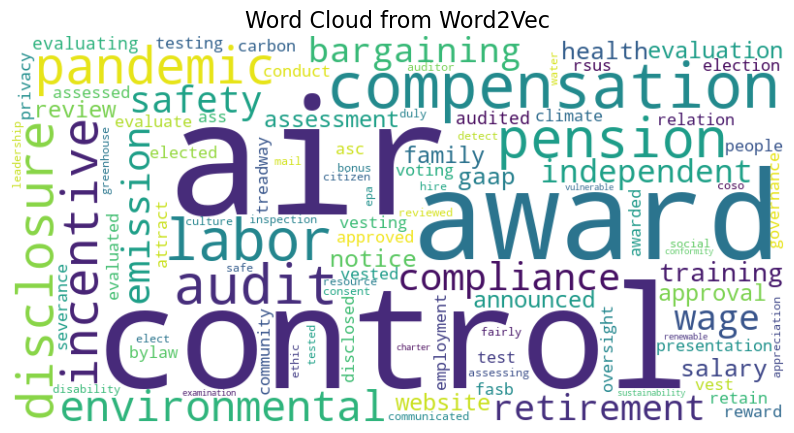

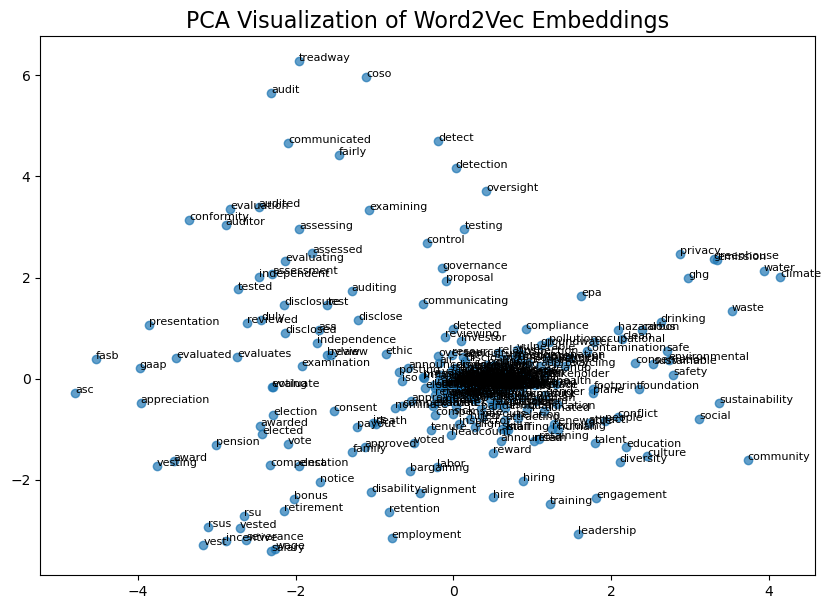

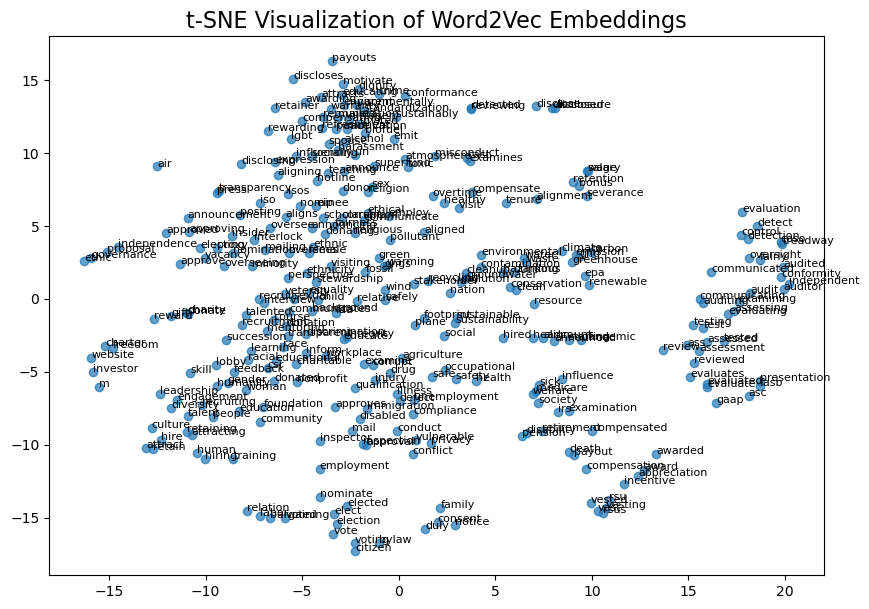

In [1]:
import os
import json
import re
import pandas as pd
import numpy as np
import nltk
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize NLP tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    """
    Preprocess text by:
    - Removing Unicode escape sequences
    - Removing numbers
    - Removing punctuation
    - Lowercasing
    - Tokenizing
    - Removing stopwords
    - Lemmatizing
    """
    text = text.encode().decode("unicode_escape")  # Decode Unicode escape sequences
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    
    # Tokenize, remove stopwords, and lemmatize
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word in esg_terms]
    return filtered_tokens

# Paths
x_folder_path = r"C:\Users\sabri\OneDrive\桌面\論文\論文code\Air transportation SIC 4512\ML dataset\2013-2022_all (X)"
y_file_path = r"C:\Users\sabri\OneDrive\桌面\論文\論文code\Air transportation SIC 4512\ML dataset\Annual ESG score (Y)\Combined_ESG_Scores.csv"
test_file_path = r"C:\Users\sabri\OneDrive\桌面\論文\論文code\Air transportation SIC 4512\ML dataset\Test data"
esg_file_path = r"C:\Users\sabri\OneDrive\桌面\論文\論文code\Air transportation SIC 4512\ESG wordlist.csv"  # Path to the ESG wordlist


# Load ESG dictionary
esg_dict = pd.read_csv(esg_file_path)
esg_terms = set(esg_dict['terms'].str.lower())  # Convert to lowercase for case-insensitive matching

# Load ESG scores (Y data)
y_data = pd.read_csv(y_file_path)
esg_scores = y_data['ESG'].tolist()  # Assuming the column name is 'ESG'

# Step 1: Load and preprocess text data
documents = []

for filename in os.listdir(x_folder_path):
    if filename.endswith('.json'):
        with open(os.path.join(x_folder_path, filename), 'r') as file:
            data = json.load(file)
            content = json.dumps(data)  # Convert JSON to string
            tokens = preprocess_text(content)
            documents.append(tokens)

# Step 2: Train Word2Vec model
word2vec_model = Word2Vec(sentences=documents, vector_size=100, window=5, min_count=2, workers=4, sg=0)
print("Word2Vec model trained successfully!")

# Convert Word2Vec embeddings into document-level embeddings (average pooling)
def compute_document_embeddings(documents, model):
    document_embeddings = []
    for doc in documents:
        word_vectors = [model.wv[word] for word in doc if word in model.wv]
        if word_vectors:
            document_embedding = np.mean(word_vectors, axis=0)
        else:
            document_embedding = np.zeros(model.vector_size)
        document_embeddings.append(document_embedding)
    return np.array(document_embeddings)

# Compute embeddings for training data
X = compute_document_embeddings(documents, word2vec_model)

# Step 3: Train a regression model to predict ESG scores
X_train, X_test, y_train, y_test = train_test_split(X, esg_scores, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Step 4: Predict ESG scores for new test data
new_documents = []

for filename in os.listdir(test_file_path):
    if filename.endswith('.json'):
        with open(os.path.join(test_file_path, filename), 'r') as file:
            data = json.load(file)
            content = json.dumps(data)  # Convert JSON to string
            tokens = preprocess_text(content)
            new_documents.append(tokens)

# Compute embeddings for test data
new_X = compute_document_embeddings(new_documents, word2vec_model)

# Predict ESG scores for new test data
new_y_pred = regressor.predict(new_X)
for idx, score in enumerate(new_y_pred, start=1):
    print(f"File {idx}: Predicted ESG Score: {score}")

# Step 5: Word Cloud Visualization
def generate_wordcloud_from_word2vec(model, title="Word Cloud from Word2Vec"):
    vocab = model.wv.key_to_index.keys()
    word_scores = {word: model.wv.get_vecattr(word, 'count') for word in vocab}
    wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100)
    wordcloud.generate_from_frequencies(word_scores)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

generate_wordcloud_from_word2vec(word2vec_model)

# Step 6: Visualize Word Embeddings
def visualize_embeddings(model, reduction_method='pca', title="Word Embedding Visualization"):
    words = list(model.wv.key_to_index.keys())
    vectors = model.wv[words]

    if reduction_method == 'pca':
        pca = PCA(n_components=2)
        reduced_vectors = pca.fit_transform(vectors)
    elif reduction_method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced_vectors = tsne.fit_transform(vectors)
    else:
        raise ValueError("Invalid reduction_method. Use 'pca' or 'tsne'.")

    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=8)
    plt.title(title, fontsize=16)
    plt.show()

# PCA Visualization
visualize_embeddings(word2vec_model, reduction_method='pca', title="PCA Visualization of Word2Vec Embeddings")

# t-SNE Visualization
visualize_embeddings(word2vec_model, reduction_method='tsne', title="t-SNE Visualization of Word2Vec Embeddings")


Top 20 Word Frequencies:
air: 8044
control: 6326
award: 4554
compensation: 3118
labor: 2507
audit: 2291
pension: 2271
pandemic: 1984
disclosure: 1877
incentive: 1856


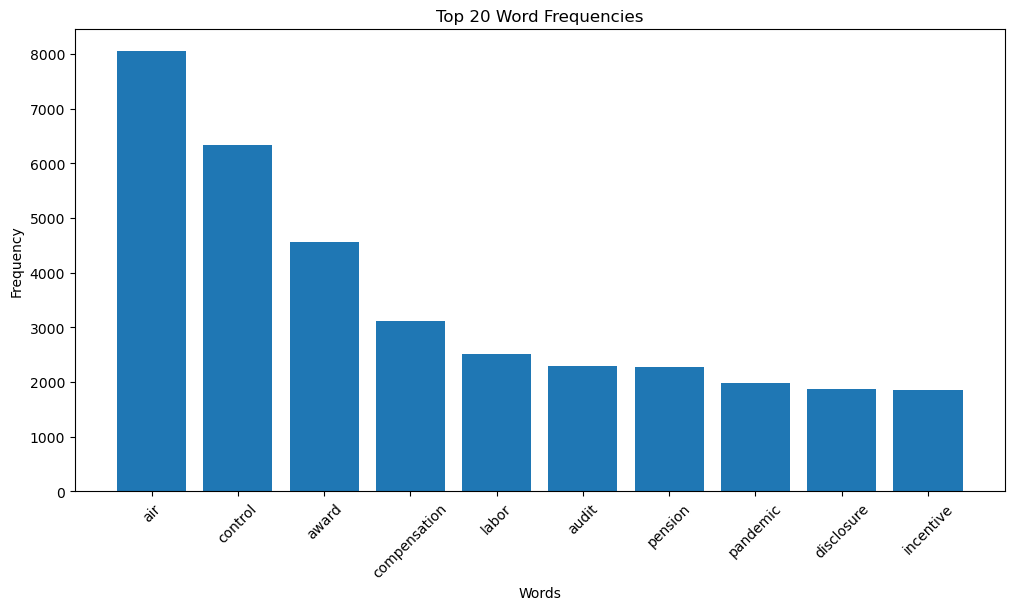

In [2]:
from collections import Counter

# Step 1: Flatten all tokenized documents into a single list of words
all_words = [word for doc in documents for word in doc]

# Step 2: Count word frequencies using Counter
word_frequencies = Counter(all_words)

# Step 3: Get the top 20 most frequent words
top_20_words = word_frequencies.most_common(10)

# Step 4: Display the top 20 words and their frequencies
print("Top 20 Word Frequencies:")
for word, freq in top_20_words:
    print(f"{word}: {freq}")

# Step 5: Visualize the top 20 word frequencies using a bar chart
def plot_top_words(top_words):
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.title("Top 20 Word Frequencies")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(top_20_words)


Top ESG-Related Word Frequencies:
air: 8044
control: 6326
award: 4554
compensation: 3118
labor: 2507
audit: 2291
pension: 2271
pandemic: 1984
disclosure: 1877
incentive: 1856
environmental: 1352
compliance: 1317
emission: 1287
safety: 1212
retirement: 1173
wage: 1151
bargaining: 1118
independent: 994
training: 972
health: 863
gaap: 859
notice: 838
salary: 838
assessment: 799
evaluation: 781
website: 760
approval: 747
family: 724
announced: 720
review: 712


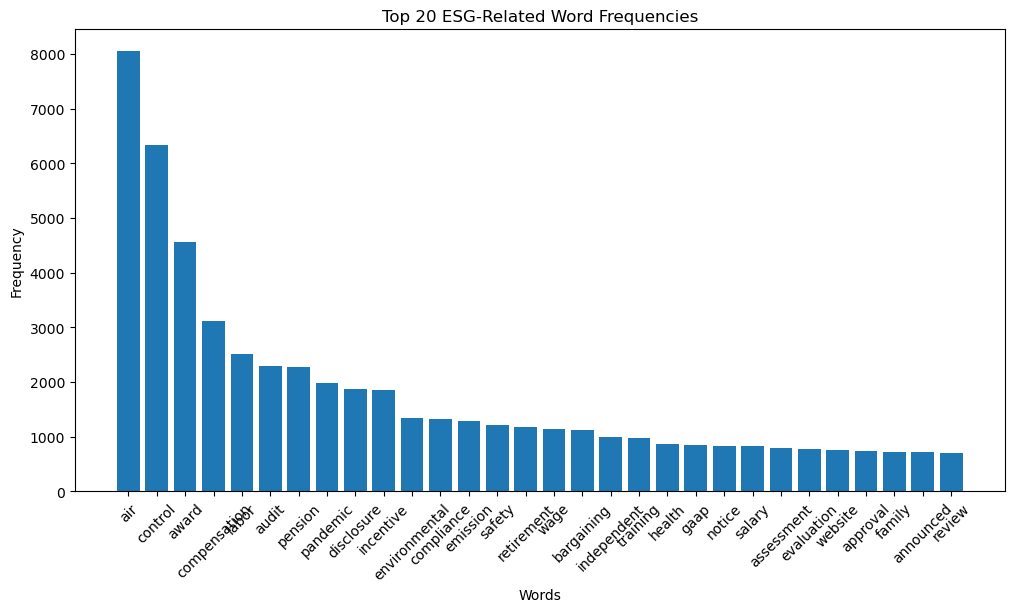

In [9]:
from collections import Counter

# Step 2: Flatten all tokenized documents into a single list of words
all_words = [word for doc in documents for word in doc]

# Step 3: Count word frequencies using Counter
word_frequencies = Counter(all_words)

# Step 4: Filter frequencies for ESG-related terms
esg_word_frequencies = {word: freq for word, freq in word_frequencies.items() if word in esg_terms}

# Step 5: Sort the ESG-related terms by frequency and get the top 30
top_esg_words = sorted(esg_word_frequencies.items(), key=lambda x: x[1], reverse=True)[:30]

# Step 6: Display the top ESG-related words and their frequencies
print("Top ESG-Related Word Frequencies:")
for word, freq in top_esg_words:
    print(f"{word}: {freq}")

# Step 7: Visualize the top ESG-related word frequencies using a bar chart
def plot_top_esg_words(top_words):
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.title("Top 20 ESG-Related Word Frequencies")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

plot_top_esg_words(top_esg_words)
